In [111]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.utils import resample
from sklearn import metrics
import itertools

In [127]:
cities = ['Ahmedabad','Bangalore','Chennai','Delhi','Hyderabad','Kolkata','Mumbai','Pune']

for index,city in enumerate(cities):
    path = f'./data/{city}_rent.csv'
    if index == 0:
        data = pd.read_csv(path)
        data['city'] = list(itertools.repeat(city,len(data)))
    else:
        df = pd.read_csv(path)
        df['city'] = list(itertools.repeat(city,len(df)))
        data = pd.concat([data,df])


In [128]:
data = data.reset_index().drop('index',axis=1)
data

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,OWNER,2.0,BHK,Apartment,Bodakdev,"20,000",1450.0,Furnished,2 bathrooms,Ahmedabad
1,OWNER,1.0,RK,Studio Apartment,CG Road,"7,350",210.0,Semi-Furnished,1 bathrooms,Ahmedabad
2,OWNER,3.0,BHK,Apartment,Jodhpur,"22,000",1900.0,Unfurnished,3 bathrooms,Ahmedabad
3,OWNER,2.0,BHK,Independent House,Sanand,"13,000",1285.0,Semi-Furnished,2 bathrooms,Ahmedabad
4,OWNER,2.0,BHK,Independent House,Navrangpura,"18,000",1600.0,Furnished,2 bathrooms,Ahmedabad
...,...,...,...,...,...,...,...,...,...,...
196833,OWNER,1.0,BHK,Apartment,Chinchwad,"13,250",650.0,Semi-Furnished,1 bathrooms,Pune
196834,OWNER,1.0,RK,Studio Apartment,Wadgaon Sheri,"7,000",350.0,Unfurnished,1 bathrooms,Pune
196835,OWNER,1.0,BHK,Apartment,Kothrud,"8,500",389.0,Semi-Furnished,1 bathrooms,Pune
196836,AGENT,1.0,BHK,Apartment,Wakad,"16,500",670.0,Semi-Furnished,2 bathrooms,Pune


In [129]:
print(f"Features: {', '.join(data.columns)}")
print(f'Numero de filas: {data.shape[0]}')
print(f'Numero de Columnas: {data.shape[1]}')

Features: seller_type, bedroom, layout_type, property_type, locality, price, area, furnish_type, bathroom, city
Numero de filas: 196838
Numero de Columnas: 10


In [130]:
df_dtypes = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         data.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,city,0,object
1,bedroom,1061,float64
2,layout_type,1061,object
3,property_type,1061,object
4,price,1061,object
5,area,1061,float64
6,furnish_type,1061,object
7,locality,1062,object
8,seller_type,1064,object
9,bathroom,3358,object


In [131]:
target = 'price'
categorical_columns = ['city','layout_type','property_type','furnish_type','locality','seller_type','bathroom']
continuos_columns = ['bedroom','area']

Eliminar las filas que tengan el target null

In [132]:
data = data.dropna(subset=[target])

In [133]:
data[target].isnull().sum()

0

La variable objetivo (Price) aparece como object y deberia ser float

In [134]:
data[target]= data[target].str.replace(',','.',regex=False).astype(float)

C:\Users\remoteUser\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Analizar las distribuciones de cada columna

<Figure size 432x288 with 0 Axes>

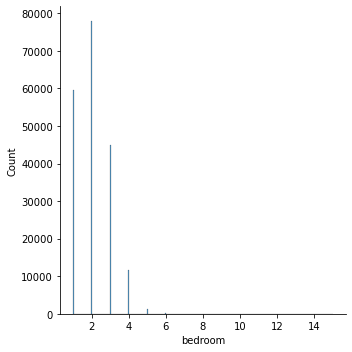

<Figure size 432x288 with 0 Axes>

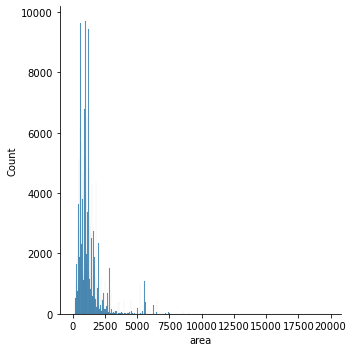

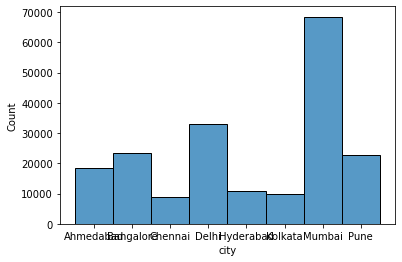

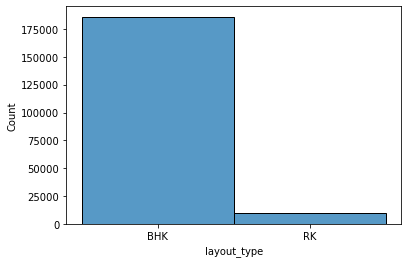

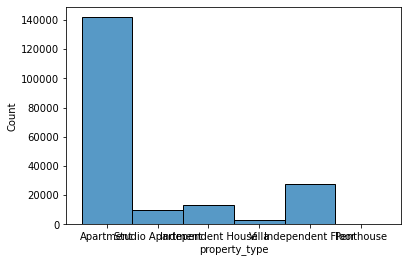

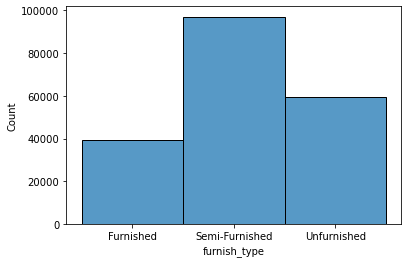

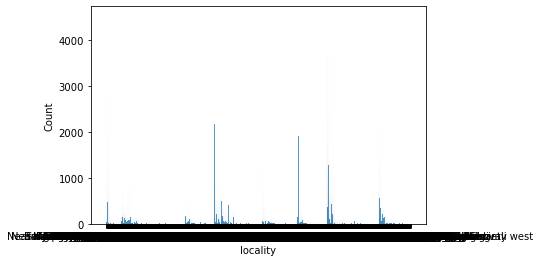

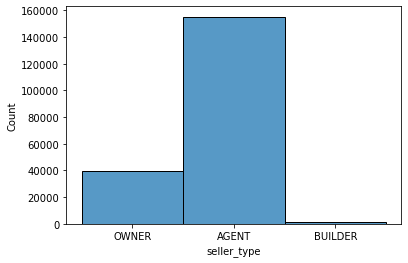

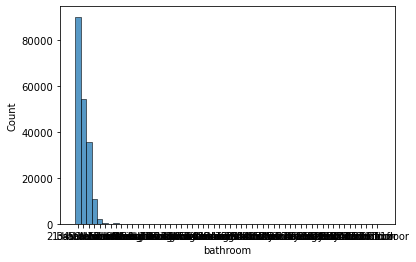

In [135]:
for column in continuos_columns:
    plt.figure()
    sns.displot(x=column, data=data)
    
for column in categorical_columns:
    plt.figure()
    sns.histplot(x=column, data=data,discrete=True)

In [136]:
data['bathroom'].value_counts()

2 bathrooms                 90046
1 bathrooms                 54283
3 bathrooms                 35452
4 bathrooms                 10674
5 bathrooms                  1930
6 bathrooms                   381
East facing                   169
7 bathrooms                    80
North facing                   66
9 bathrooms                    55
8 bathrooms                    52
NorthEast facing               51
10 bathrooms                   34
West facing                    31
Grfloor                        19
NorthWest facing               17
SouthWest facing               15
1 of 4floor                    13
SouthEast facing               10
15 bathrooms                    8
2 of 4floor                     8
South facing                    6
14 bathrooms                    6
16 bathrooms                    6
3 of 4floor                     5
1 of 3floor                     5
3 of 3floor                     5
12 bathrooms                    5
Family only                     4
2 of 5floor   

In [137]:
data['locality'].value_counts()

Thane West             4518
Chembur                3665
Andheri East           3549
Bopal                  2941
Kharghar               2618
                       ... 
Selimpur Road             1
M G ROAD Haridevpur       1
Veerannapalya             1
Chandra Layout            1
Aundh Gaon                1
Name: locality, Length: 4173, dtype: int64

<b>La localidad se puede encodear con catboost</b>

<b>Para el caso de los baños hay que convertila en una variable continua</b>

### Convertir la columna bathroom

In [138]:
#tomar los primeros dos caracteres, si se puede convertir a numerico entonces ese es el valor, sino devolver nan

def convert_bathroom(value):
    if str(value)[:2].strip().isdigit():
        return int(value[:2].strip())
    return np.nan

data['bathroom'] = data['bathroom'].apply(convert_bathroom)

C:\Users\remoteUser\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
data['bathroom'].value_counts()

2.0     90063
1.0     54305
3.0     35464
4.0     10678
5.0      1932
6.0       384
7.0        83
9.0        56
8.0        52
10.0       36
15.0        9
12.0        6
16.0        6
14.0        6
11.0        3
19.0        2
17.0        2
18.0        1
Name: bathroom, dtype: int64

In [140]:
print(f'Nulls: {data["bathroom"].isnull().sum()}')

Nulls: 2689


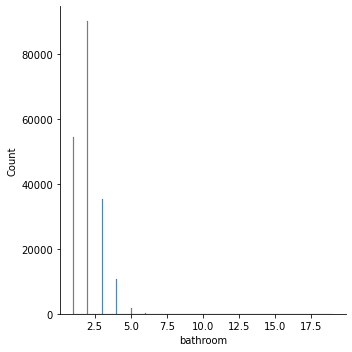

In [141]:
sns.displot(x="bathroom", data=data)

Como bathroom se convirtio en continua hay que sacarla de la lista de categoricas y ponerla en la lista de continuas

In [142]:
categorical_columns = categorical_columns[:-1]
continuos_columns.append('bathroom')

### Encodear las variables categoricas

In [143]:
catboost_encoder = ce.CatBoostEncoder(cols=categorical_columns)
data_encoded = catboost_encoder.fit_transform(data,data[target])
data_encoded

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,22.949720,2.0,22.949720,22.949720,22.949720,20.00,1450.0,22.949720,2.0,22.949720
1,21.474860,1.0,22.949720,22.949720,22.949720,7.35,210.0,22.949720,1.0,21.474860
2,16.766573,3.0,21.474860,21.474860,22.949720,22.00,1900.0,22.949720,3.0,16.766573
3,18.074930,2.0,21.649907,22.949720,22.949720,13.00,1285.0,15.149860,2.0,18.074930
4,17.059944,2.0,19.487430,17.974860,22.949720,18.00,1600.0,21.474860,2.0,17.059944
...,...,...,...,...,...,...,...,...,...,...
196833,15.722447,1.0,23.591491,25.366569,16.439383,13.25,650.0,23.440444,1.0,18.823169
196834,15.722384,1.0,10.762337,10.762337,19.219359,7.00,350.0,16.902091,1.0,18.822924
196835,15.722162,1.0,23.591435,25.366484,19.502942,8.50,389.0,23.440339,1.0,18.822406
196836,24.824102,1.0,23.591354,25.366365,19.098568,16.50,670.0,23.440185,2.0,18.821953


### Correlacion

<AxesSubplot:>

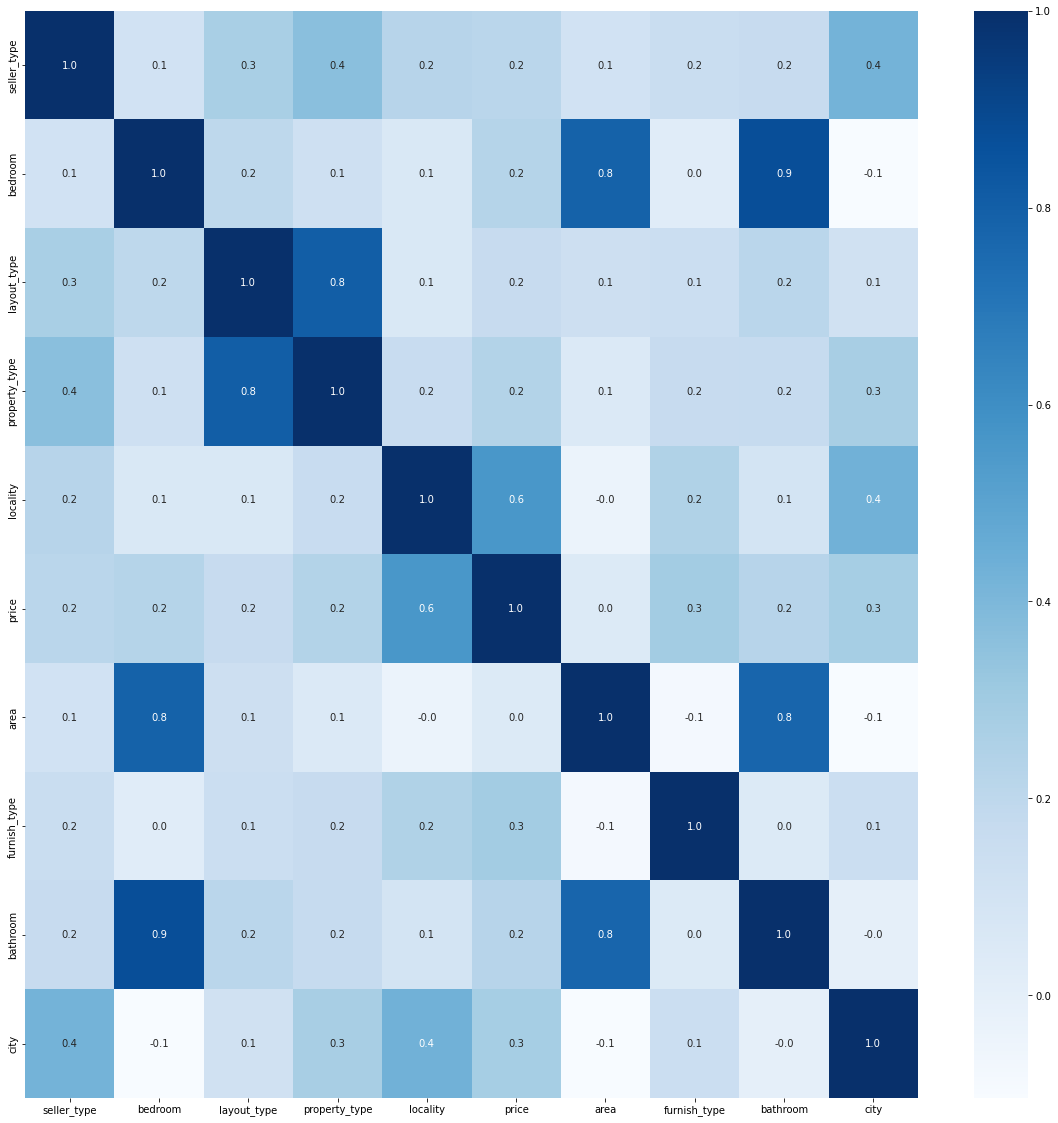

In [144]:
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')

### Analisis de outliers

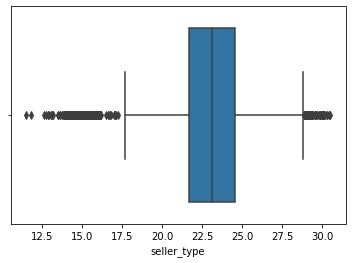

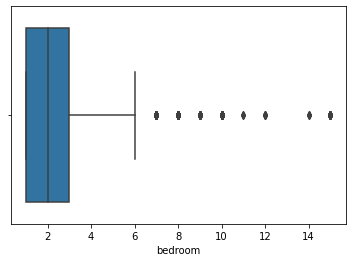

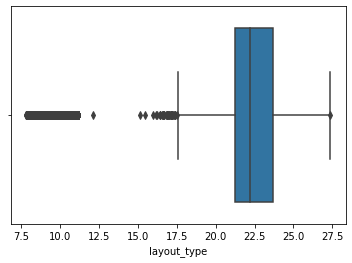

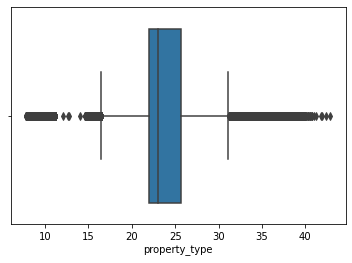

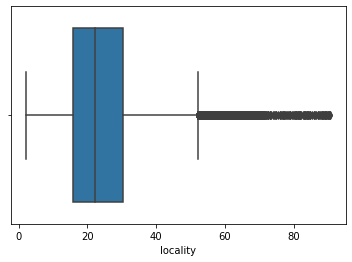

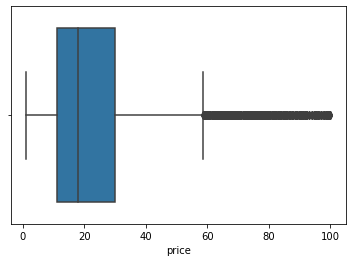

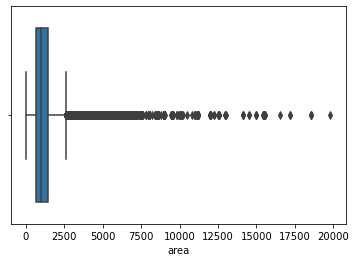

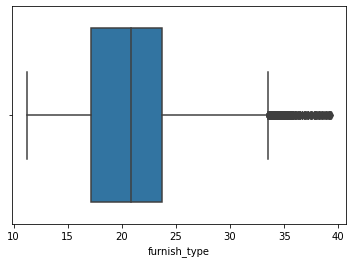

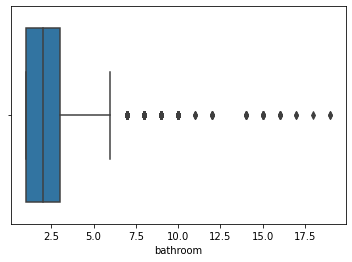

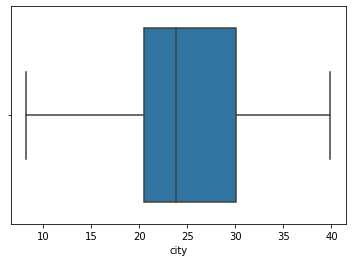

In [145]:
for column in data_encoded:
    plt.figure()
    sns.boxplot(x=column, data=data_encoded)

### Analisis de dimensionalidad

In [146]:
X = data_encoded.drop(target,axis=1)
y = data_encoded[target]

In [147]:
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [149]:
sel_ridge = SelectFromModel(Ridge(), threshold = 0.009)
sel_ridge.fit(X_train, y_train)

SelectFromModel(estimator=Ridge(), threshold=0.009)

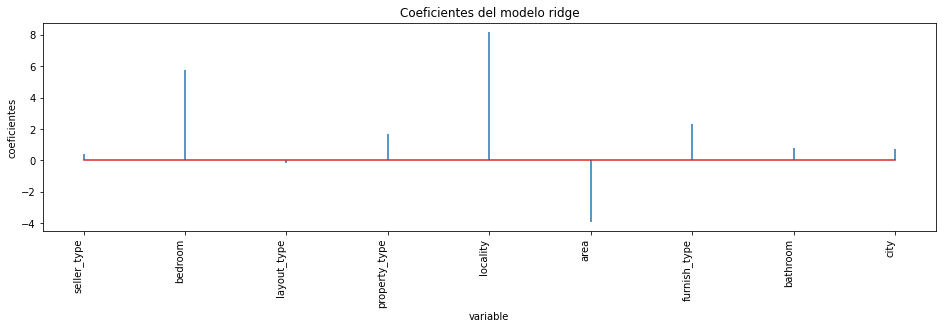

In [150]:
df_coeficientes = pd.DataFrame(
    {'predictor': X_train.columns,
     'coef': sel_ridge.estimator_.coef_.flatten()}
)

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [151]:
selected_features = X_train.columns[sel_ridge.get_support()]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_features)))

total features: 9
selected features: 9


### PCA

In [153]:
pca = PCA(n_components='mle')

pca.fit(X_train[selected_features])
X_train_pca = pca.transform(X_train[selected_features])
X_test_pca = pca.transform(X_test[selected_features])
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.columns = ['PCA_'+str(i) for i in X_train_pca.columns]
X_test_pca.columns = ['PCA_'+str(i) for i in X_test_pca.columns]

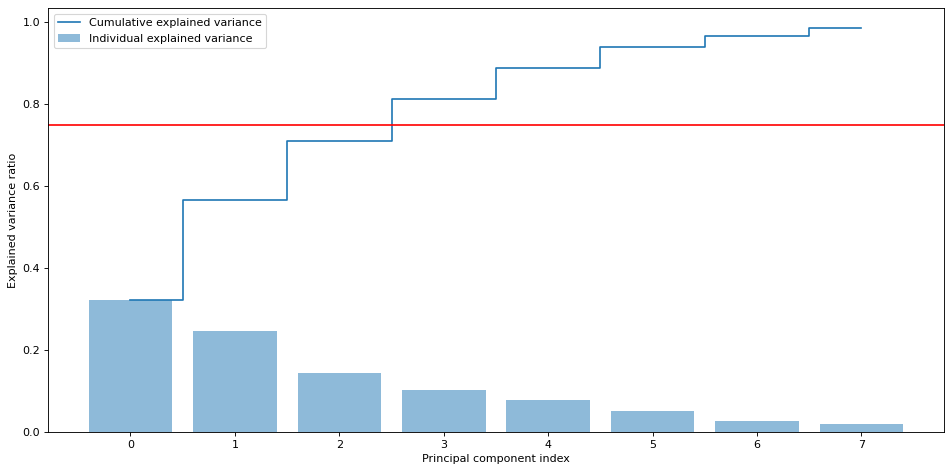

In [154]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [155]:
print(f'Numero de features: {X_train_pca.shape[1]}')

Numero de features: 8


#### Probar un modelo de regresion con y sin PCA

In [156]:
reg_pca = LinearRegression()
reg_pca.fit(X_train_pca,y_train)

LinearRegression()

In [163]:
metrics.mean_absolute_percentage_error(reg_pca.predict(X_test_pca),y_test)

0.6018514941124854

In [160]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [162]:
metrics.mean_absolute_percentage_error(reg.predict(X_test),y_test)

0.5996403263306378

El modelo sin PCA tiene un error menor

## exportar dataset

In [164]:
data.to_csv('./data/data.csv')